**YOUR NAMES HERE**

Spring 2025

CS 444: Deep Learning

In [114]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=4)

# Automatically reload your external source code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of transformer_layers failed: Traceback (most recent call last):
  File "c:\Users\AlexL\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\extensions\autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\AlexL\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\extensions\autoreload.py", line 484, in superreload
    update_generic(old_obj, new_obj)
  File "c:\Users\AlexL\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\extensions\autoreload.py", line 381, in update_generic
    update(a, b)
  File "c:\Users\AlexL\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\extensions\autoreload.py", line 333, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\AlexL\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\extensions\autoreload.py", line 381, in update_generic
    update(a, b)
  File "c:\Users\Ale

# Project 4 | Transformers

The focus of this project is on the **Transformer neural network architecture**, which was introduced in the (now famous) paper *Attention is All you Need* by [Vaswani et al. (2017)](https://arxiv.org/abs/1706.03762). This neural network architecture is THE foundation of all modern large language models (e.g. OpenAI's GPT line of models, Anthropic Claude, Google Gemini, Meta Llama, DeepSeek, etc.). You will implement and train transformer networks on large amounts of text data. The transformer networks in this project adhere to the general structure of OpenAI's **Generative Pretrained Transformer (GPT)** models.

Once you build on your deep learning library to support the transformer architecture in this notebook, you will train small transformers to add and multiply numbers (i.e. evaluate strings of arithmetic operations, such as `'1+1='`). The last part of the project focuses on training larger transformers on a large text corpus — the entire works of William Shakespeare. When you prompt your transformers with some starter text, they will generate novel text that follows your prompt and generally resembles the text used to train the network (e.g. a Shakespearian play).

<!-- #### Week 1: Build a transformer neural network -->

![Some fun](images/transformer.png)

## Task 1: Generate the addition dataset

In this task, you will write code to generate and preprocess a dataset composed of strings that represent arithmetic addition expressions involving up to 2 digit non-negative integer operands. For example, `'20+30=50'` and `'2+30=32'`are allowed, but not `'300+5=305'`. You will train a transformer on a large numbers of such expressions then you will prompt it to generate the answer to the right of the equals sign. For example, once trained you could prompt the transformer with `'21+23='` and it should return `'44'`.

#### Data format

In this project, we will be working with text data and we are implementing a **character-level model** (unlike the word-level model used in the Word Embedding project). This means that each data sample is a sequence of `T` characters (i.e. tokens), which, for example, could be a part of a sentence or the characters that make up an arithmetic expression. So all the data samples in the dataset will have shape `(N, T)`. Just like in the Word Embedding project, we int-code each char/token in the dataset based on the character's position in the vocabulary.

In [115]:
from addition_dataset import *

### 1a. Verify `make_addition_expressions` outputs

In the cell below, use the provided `make_addition_expressions` to generate 25,000 addition expressions involving at most 2 digit operands (i.e. maximum operand of `99`). Use the default random seed. Assign the list of addition expressions to a variable called `addition_ds` and the vocabulary dictionary to a variable called `char2ind_map`.

When executed, the function should print:

```
First 5/25000 expressions:
  ['4', '7', '+', '5', '1', '=', '9', '8', '.', '#']
  ['7', '5', '+', '9', '5', '=', '1', '7', '0', '.']
  ['3', '+', '1', '4', '=', '1', '7', '.', '#', '#']
  ['8', '2', '+', '9', '4', '=', '1', '7', '6', '.']
  ['2', '4', '+', '3', '1', '=', '5', '5', '.', '#']
```

#### Token encoding

To aid in interpretability of the int-coded tokens, we will represent the each `0-9` digit of the integer operands being summed as `0-9` in the int coding. We map the following chars to the next available ints in our coding scheme:
- `'+'` → 10
- `'='` → 11

We introduce a "fake" token `'.'` (int code: 12) within our vocabulary, our data samples, and our labels, which indicates the end of each addition expression (**end token**). For example `'47+51=98.'`. This helps the transformer know when the last "real" token/char in each addition expression has been reached (i.e. there are no more numbers to the right) and when it generates text after training, the transformer can output the int code corresponding `'.'` to signify that it is done generating text.

We introduce another "fake" token `'#'` (int code: 13), which we call the **padding token**. Our transformers must be trained on fixed-length sequences, but different addition expressions have different length (i.e. the length of `'1+1=2'` is shorter than `'1+9=10'`). To overcome this issue with samples in our dataset, we use the padding token to right-pad any expression that has fewer characters than our longest supported expression `'99+99=198'`.

In [116]:
addition_ds, char2ind_map = make_addition_expressions(25000, 2)

First 5/25000 expressions:
  ['4', '7', '+', '5', '1', '=', '9', '8', '.', '#']
  ['7', '5', '+', '9', '5', '=', '1', '7', '0', '.']
  ['3', '+', '1', '4', '=', '1', '7', '.', '#', '#']
  ['8', '2', '+', '9', '4', '=', '1', '7', '6', '.']
  ['2', '4', '+', '3', '1', '=', '5', '5', '.', '#']


### 1b. Create addition int-coded dataset samples and labels

To do this we must
- convert each char in each addition expression into an int-code (*using the vocabulary*).
- define the "class labels" or the characters we want the transformer to predict at each time step. This is simply the int code of next character in each the expression to the right of the current one. For example, for `'9+2=11'` the first token in the data sample is `9` and the first class label is `10` (the int code for `'+'`).

Implement `make_addition_samples_and_labels` in `addition_dataset.py` to perform the above tasks then test your code below.

In [117]:
x_int_test, y_int_test = make_addition_samples_and_labels(addition_ds, char2ind_map)

print('First few samples (encoded):')
for i in range(5):
    print(x_int_test[i])
print('First few labels (encoded):')
for i in range(5):
    print(y_int_test[i])

First few samples (encoded):
[4, 7, 10, 5, 1, 11, 9, 8, 12]
[7, 5, 10, 9, 5, 11, 1, 7, 0]
[3, 10, 1, 4, 11, 1, 7, 12, 13]
[8, 2, 10, 9, 4, 11, 1, 7, 6]
[2, 4, 10, 3, 1, 11, 5, 5, 12]
First few labels (encoded):
[7, 10, 5, 1, 11, 9, 8, 12, 13]
[5, 10, 9, 5, 11, 1, 7, 0, 12]
[10, 1, 4, 11, 1, 7, 12, 13, 13]
[2, 10, 9, 4, 11, 1, 7, 6, 12]
[4, 10, 3, 1, 11, 5, 5, 12, 13]


The above should print:

```
First few samples (encoded):
[4, 7, 10, 5, 1, 11, 9, 8, 12]
[7, 5, 10, 9, 5, 11, 1, 7, 0]
[3, 10, 1, 4, 11, 1, 7, 12, 13]
[8, 2, 10, 9, 4, 11, 1, 7, 6]
[2, 4, 10, 3, 1, 11, 5, 5, 12]
First few labels (encoded):
[7, 10, 5, 1, 11, 9, 8, 12, 13]
[5, 10, 9, 5, 11, 1, 7, 0, 12]
[10, 1, 4, 11, 1, 7, 12, 13, 13]
[2, 10, 9, 4, 11, 1, 7, 6, 12]
[4, 10, 3, 1, 11, 5, 5, 12, 13]
```

### 1c. Create dictionary converting int-coded tokens back into chars

Your transformer will output ints — the int-coded representation of the predicted next char. For example, if the transformer outputs `'11'` that should be converted to `'='` for interpretability. 

Implement and test `make_ind2char_mapping` in `addition_dataset.py` to create the dictionary that will use the vocabulary to map int-coded representations of tokens back to chars.

In [118]:
ind2char_map = make_ind2char_mapping(char2ind_map)

print(f'Here is your ind2char_map:\n{ind2char_map}\nit should be')
print("{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '+', 11: '=', 12: '.', 13: '#'}")
print(f'Here is your char2ind_map:\n{char2ind_map}\nit should be')
print("{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '+': 10, '=': 11, '.': 12, '#': 13}")

Here is your ind2char_map:
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '+', 11: '=', 12: '.', 13: '#'}
it should be
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '+', 11: '=', 12: '.', 13: '#'}
Here is your char2ind_map:
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '+': 10, '=': 11, '.': 12, '#': 13}
it should be
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '+': 10, '=': 11, '.': 12, '#': 13}


### 1d. Convert from int-coded tokens back to characters

Because you will prompt your transformer with string input (like a chatbot) and we would like to make sense of the transformer predictions, let's write a function (`convert_int2str`) that automates the process of taking int-coded samples back into human-readable characters then test it below.

In [119]:
x_str_test = convert_int2str(x_int_test, ind2char_map)
y_str_test = convert_int2str(y_int_test, ind2char_map)

print('First few samples converted back to chars:')
for i in range(5):
    print(x_str_test[i])
print('First few labels converted back to chars:')
for i in range(5):
    print(y_str_test[i])
print()

First few samples converted back to chars:
['4', '7', '+', '5', '1', '=', '9', '8', '.']
['7', '5', '+', '9', '5', '=', '1', '7', '0']
['3', '+', '1', '4', '=', '1', '7', '.', '#']
['8', '2', '+', '9', '4', '=', '1', '7', '6']
['2', '4', '+', '3', '1', '=', '5', '5', '.']
First few labels converted back to chars:
['7', '+', '5', '1', '=', '9', '8', '.', '#']
['5', '+', '9', '5', '=', '1', '7', '0', '.']
['+', '1', '4', '=', '1', '7', '.', '#', '#']
['2', '+', '9', '4', '=', '1', '7', '6', '.']
['4', '+', '3', '1', '=', '5', '5', '.', '#']



The above cell should output:

```
First few samples:
['4', '7', '+', '5', '1', '=', '9', '8', '.']
['7', '5', '+', '9', '5', '=', '1', '7', '0']
['3', '+', '1', '4', '=', '1', '7', '.', '#']
['8', '2', '+', '9', '4', '=', '1', '7', '6']
['2', '4', '+', '3', '1', '=', '5', '5', '.']
First few labels:
['7', '+', '5', '1', '=', '9', '8', '.', '#']
['5', '+', '9', '5', '=', '1', '7', '0', '.']
['+', '1', '4', '=', '1', '7', '.', '#', '#']
['2', '+', '9', '4', '=', '1', '7', '6', '.']
['4', '+', '3', '1', '=', '5', '5', '.', '#']
```

### 1e. Create train-validation split

Implement `make_train_val_split` in `addition_dataset.py` to divide the dataset into training and validation split then run the code below to check your implementation.

In [120]:
x_train_test, y_train_test, x_val_test, y_val_test = make_train_val_split(x_int_test, y_int_test)

print(f'The training samples shape is: {x_train_test.shape} and should be (22500, 9).')
print(f'The training labels shape is: {y_train_test.shape} and should be (22500, 9).')
print(f'The validation samples shape is: {x_val_test.shape} and should be (2500, 9).')
print(f'The validation labels shape is: {y_val_test.shape} and should be (2500, 9).')

The training samples shape is: (22500, 9) and should be (22500, 9).
The training labels shape is: (22500, 9) and should be (22500, 9).
The validation samples shape is: (2500, 9) and should be (2500, 9).
The validation labels shape is: (2500, 9) and should be (2500, 9).


### 1f. Create addition dataset prompts and expected output

After training the transformer on expressions such as `'1+1=2.####'`, you will prompt it with `1+1=` and we expect it to generate `'2.'` (the `'.'` indicates it is done generating text). Let's write the `split_sum_and_answer` function to automate the process of generating the prompts and expected outputs for samples in either the train or validation sets.

In [121]:
lhs_lists, ans_lists = split_sum_and_answer(x_str_test)

print('First five training prompts and answers:')
for i in range(5):
    print(f'prompt: {lhs_lists[i]} | answer: {ans_lists[i]}')

First five training prompts and answers:
prompt: 47+51= | answer: 98.
prompt: 75+95= | answer: 170
prompt: 3+14= | answer: 17.#
prompt: 82+94= | answer: 176
prompt: 24+31= | answer: 55.


The above cell should output:

```
First five training prompts and answers:
prompt: 47+51= | answer: 98.
prompt: 75+95= | answer: 170
prompt: 3+14= | answer: 17.#
prompt: 82+94= | answer: 176
prompt: 24+31= | answer: 55.
```

### 1g. Automate addition dataset preprocessing

Call the functions that you wrote to get and preprocess the addition dataset all in one function called `get_addition_dataset`.

In [122]:
x_train_test, y_train_test, x_val_test, y_val_test, char2ind_map_test = get_addition_dataset(N=100)
print(f'The shape of your training samples is {x_train_test.shape} and it should be (90, 9).')
print(f'The shape of your training labels is {y_train_test.shape} and it should be (90, 9).')
print(f'The shape of your val samples is {x_val_test.shape} and it should be (10, 9).')
print(f'The shape of your val labels is {y_val_test.shape} and it should be (10, 9).')

# We need int coded everything! i.e. tf.int32s
assert x_train_test.dtype == tf.int32
assert y_train_test.dtype == tf.int32
assert x_val_test.dtype == tf.int32
assert y_val_test.dtype == tf.int32

First 5/100 expressions:
  ['4', '7', '+', '5', '1', '=', '9', '8', '.', '#']
  ['7', '5', '+', '9', '5', '=', '1', '7', '0', '.']
  ['3', '+', '1', '4', '=', '1', '7', '.', '#', '#']
  ['8', '2', '+', '9', '4', '=', '1', '7', '6', '.']
  ['2', '4', '+', '3', '1', '=', '5', '5', '.', '#']
The shape of your training samples is (90, 9) and it should be (90, 9).
The shape of your training labels is (90, 9) and it should be (90, 9).
The shape of your val samples is (10, 9) and it should be (10, 9).
The shape of your val labels is (10, 9) and it should be (10, 9).


## Task 2. Transformer Embedding layer

With the addition dataset ready, let's start implementing the transformer!

As with CBOW, we use an embedding layer to allow us to select the "y weights" that have indices equal to those in our current mini-batch of ints (*e.g. the int-coded addition expressions*). There are two slight changes in the transformer embedding layer compared to the `DenseEmbedding` we used in CBOW:
1. We will "turn off"/disable the bias.
2. We do not need the special casing in `compute_net_input` to handle the lazy initialization. Simply initialize the weights from within the constructor because we know both the number of input features and the number of units in the layer when building the layer (i.e. there is no lazy initialization in this layer).



In [123]:
from transformer_layers import Embedding

### 2a. Copy over deeplib files

Copy over your latest versions of `layers.py`, `block.py`, `network.py`, and `tf_util.py` from your previous project to your current working directory.

### 2b. Implement `Embedding` layer

The `Embedding` class is located in `transformer_layers.py`.

#### Test: Constructor and weights

In [124]:
tf.random.set_seed(0)
emb = Embedding('EmbeddingLayer', input_dim=5, embed_dim=3)
print('Your weights are:')
print(emb.get_wts().numpy())
print('and should be:')
print('''[[ 0.6758  0.1891 -0.1877]
 [-0.4633 -0.5531  0.2103]
 [-0.0062  0.5317  0.2695]
 [ 0.2682 -0.3156 -0.1936]
 [ 0.3549 -0.3119 -0.4293]]''')


Your weights are:
[[ 0.6758  0.1891 -0.1877]
 [-0.4633 -0.5531  0.2103]
 [-0.0062  0.5317  0.2695]
 [ 0.2682 -0.3156 -0.1936]
 [ 0.3549 -0.3119 -0.4293]]
and should be:
[[ 0.6758  0.1891 -0.1877]
 [-0.4633 -0.5531  0.2103]
 [-0.0062  0.5317  0.2695]
 [ 0.2682 -0.3156 -0.1936]
 [ 0.3549 -0.3119 -0.4293]]


#### Test: Layer summary and netAct shapes

In [125]:
test_minibatch = [[1, 2], [0, 2], [3, 4]]
emb(test_minibatch)
print('Embedding layer summary:')
print(emb)
print('it should be:')
print('Embedding layer output(EmbeddingLayer) shape: [3, 2, 3]')

Embedding layer summary:
Embedding layer output(EmbeddingLayer) shape: [3, 2, 3]
it should be:
Embedding layer output(EmbeddingLayer) shape: [3, 2, 3]


#### Test: Activation values

In [126]:
print('For the test mini-batch, the netActs are:')
print(emb(test_minibatch).numpy())
print('and they should be:')
print('''[[[-0.4633 -0.5531  0.2103]
  [-0.0062  0.5317  0.2695]]

 [[ 0.6758  0.1891 -0.1877]
  [-0.0062  0.5317  0.2695]]

 [[ 0.2682 -0.3156 -0.1936]
  [ 0.3549 -0.3119 -0.4293]]]''')

For the test mini-batch, the netActs are:
[[[-0.4633 -0.5531  0.2103]
  [-0.0062  0.5317  0.2695]]

 [[ 0.6758  0.1891 -0.1877]
  [-0.0062  0.5317  0.2695]]

 [[ 0.2682 -0.3156 -0.1936]
  [ 0.3549 -0.3119 -0.4293]]]
and they should be:
[[[-0.4633 -0.5531  0.2103]
  [-0.0062  0.5317  0.2695]]

 [[ 0.6758  0.1891 -0.1877]
  [-0.0062  0.5317  0.2695]]

 [[ 0.2682 -0.3156 -0.1936]
  [ 0.3549 -0.3119 -0.4293]]]


### 2c. Questions

**Question 1:** In the above test code, use minimal jargon to explain what each of the three values in the netAct shape `[3, 2, 3]` mean **and** where they came from.

**Answer 1:** We have the # of batches, 3... then we have T=2, so how many chars. in each sequence... finally, we chose to have H=3, the embedding dimension

## Task 3. Implement the Transformer Block

Analogous to Inception Net and ResNet, transformers contain a fundamental block called the Transformer Block that is copy-pasted many times sequentially in the network. Since there are fair number of layers within the Transformer Block, we will define several "helper blocks" or "subblocks" to help us make the organization more manageable. These helper blocks are:
1. `QueryKeyValueBlock`: Handles the projection/embedding/mapping of the input signal into the three parallel `Dense` layers that learn the attention queries, keys, and values.
2. `AttentionBlock`: Implements the attention mechanism (*involves a Dropout layer that operates on the attention values*).
3. `MultiHeadAttentionBlock`: Organizes the sequential processing of input signals through the above two blocks as well as subsequent Dense and Dropout layers: `QueryKeyValueBlock` → `AttentionBlock` → `Dense` layer → `Dropout` layer.
4. `MLPBlock`: Final stages of the transformer block. `Dense` layer → `Dense` layer → `Dropout` layer.

### 3a. Layer normalization

Transformers replace batch normalization with **layer normalization**. Fortunately, layer normalization ("layer norm") is much simpler to implement than batch normalization because it does NOT require any special handling of training and non-training network state and there are no moving averages to manage! If we think of batch norm as the middle of the netIn and netAct "sandwich", layer norm shuffles the order and becomes the "bottom bun":

Layer norm → netIn → netAct

Make the following updates to `layer.py` to add support for layer normalization:

1. `Layer` constructor: If you are not already, set the parameter `do_layer_norm` as an instance variable.
2. Implement the `init_layernorm_params` method in `Layer` to initialize the parameters related to layer norm.
3. Implement the `compute_layer_norm` method in `Layer` to compute the layer normalization on the input the layer receives from the previous layer/block.
4. `Layer` `__call__` method: Add code to support Layer norm BEFORE computing net_in. If we are doing layer norm in the layer, call `compute_layer_norm` on the layer's input. Reassign `x` as the output of the layer norm computation. If the layer norm gain parameter is still `None` before computing the layer norm, call the `init_layernorm_params` method.

In [127]:
from layers import Dense

#### Test: Layer normalization (2D input, linear activation)

In [128]:
tf.random.set_seed(0)
x_test = tf.random.uniform(shape=(2, 3))
test_dense = Dense('testDense', 4, activation='linear', wt_init='he', do_layer_norm=True)
test_net_acts = test_dense(x_test)
print('Your netActs are:')
print(test_net_acts)
print('and should be:')
print('''tf.Tensor(
[[ 0.4998 -0.2505  1.0032 -1.4304]
 [ 0.5902 -0.1433  1.1012 -1.5475]], shape=(2, 4), dtype=float32)''')

Your netActs are:
tf.Tensor(
[[ 0.4998 -0.2505  1.0032 -1.4304]
 [ 0.5902 -0.1433  1.1012 -1.5475]], shape=(2, 4), dtype=float32)
and should be:
tf.Tensor(
[[ 0.4998 -0.2505  1.0032 -1.4304]
 [ 0.5902 -0.1433  1.1012 -1.5475]], shape=(2, 4), dtype=float32)


#### Test: Layer normalization (2D input, ReLU activation)

In [129]:
tf.random.set_seed(1)
x_test = tf.random.uniform(shape=(4, 7))
test_dense = Dense('testDense', 3, activation='relu', wt_init='he', do_layer_norm=True)
test_net_acts = test_dense(x_test)
print('Your netActs are:')
print(test_net_acts)
print('and should be:')
print('''tf.Tensor(
[[0.4429 1.035  0.    ]
 [1.2696 0.5866 0.8557]
 [0.     0.     2.2657]
 [0.     0.     2.0688]], shape=(4, 3), dtype=float32)''')

Your netActs are:
tf.Tensor(
[[0.4429 1.035  0.    ]
 [1.2696 0.5866 0.8557]
 [0.     0.     2.2657]
 [0.     0.     2.0688]], shape=(4, 3), dtype=float32)
and should be:
tf.Tensor(
[[0.4429 1.035  0.    ]
 [1.2696 0.5866 0.8557]
 [0.     0.     2.2657]
 [0.     0.     2.0688]], shape=(4, 3), dtype=float32)


#### Test: Layer normalization (3D input, linear activation)

3D input to a Dense layer seems odd, but this will happen due to the presence of the sequences.

In [130]:
tf.random.set_seed(2)
x_test = tf.random.uniform(shape=(2, 4, 3))
test_dense = Dense('testDense', 5, activation='linear', wt_init='he', do_layer_norm=True)
test_net_acts = test_dense(x_test)
print('Your netActs are:')
print(test_net_acts)
print('and should be:')
print('''tf.Tensor(
[[[ 0.5571  1.7315  1.3083 -0.7988 -1.6684]
  [ 0.5577  0.2769  1.8077  0.0518 -0.9832]
  [-0.228  -2.0974 -0.0605  1.1388  1.3377]
  [ 0.5715  1.6396  1.3886 -0.7396 -1.647 ]]

 [[-0.5426 -0.1613 -1.7958 -0.1136  0.9057]
  [-0.1164  1.5696 -0.9337 -0.9621 -0.5623]
  [-0.1331 -2.0135  0.2345  1.1261  1.1531]
  [ 0.5502  1.7635  1.2736 -0.8201 -1.6728]]], shape=(2, 4, 5), dtype=float32)''')

Your netActs are:
tf.Tensor(
[[[ 0.5571  1.7315  1.3083 -0.7988 -1.6684]
  [ 0.5577  0.2769  1.8077  0.0518 -0.9832]
  [-0.228  -2.0974 -0.0605  1.1388  1.3377]
  [ 0.5715  1.6396  1.3886 -0.7396 -1.647 ]]

 [[-0.5426 -0.1613 -1.7958 -0.1136  0.9057]
  [-0.1164  1.5696 -0.9337 -0.9621 -0.5623]
  [-0.1331 -2.0135  0.2345  1.1261  1.1531]
  [ 0.5502  1.7635  1.2736 -0.8201 -1.6728]]], shape=(2, 4, 5), dtype=float32)
and should be:
tf.Tensor(
[[[ 0.5571  1.7315  1.3083 -0.7988 -1.6684]
  [ 0.5577  0.2769  1.8077  0.0518 -0.9832]
  [-0.228  -2.0974 -0.0605  1.1388  1.3377]
  [ 0.5715  1.6396  1.3886 -0.7396 -1.647 ]]

 [[-0.5426 -0.1613 -1.7958 -0.1136  0.9057]
  [-0.1164  1.5696 -0.9337 -0.9621 -0.5623]
  [-0.1331 -2.0135  0.2345  1.1261  1.1531]
  [ 0.5502  1.7635  1.2736 -0.8201 -1.6728]]], shape=(2, 4, 5), dtype=float32)


### 3b. Implement `QueryKeyValueBlock`

The class for this block is in `transformer_blocks.py`. This block handles the projection/embedding/mapping of the input signal into the three parallel `Dense` layers that learn the attention queries, keys, and values. It projects the input signal from `H_embed` in the `Embedding` layer to `H_qkv` units in each of the queries, keys, and values `Dense` layers.

In [131]:
from transformer_blocks import QueryKeyValueBlock

#### Test: `QueryKeyValueBlock`

In [132]:
tf.random.set_seed(0)
x_q = tf.random.uniform(shape=(2, 4, 7))
x_k = tf.random.uniform(shape=(2, 4, 7))
x_v = tf.random.uniform(shape=(2, 4, 7))
qkv = QueryKeyValueBlock('test', units=3, prev_layer_or_block=None)
act_q, act_k, act_v = qkv(x_q, x_k, x_v)
print(f'Your queries shape={act_q.shape} and should be (2, 4, 3)')
print(f'Your keys shape={act_q.shape} and should be (2, 4, 3)')
print(f'Your values shape={act_q.shape} and should be (2, 4, 3)')
print(f'Your queries for 1st sample:')
print(act_q[0].numpy())
print('and they should be:')
print('''[[-0.1059  0.0967  0.9469]
 [ 0.565  -0.3605 -0.0556]
 [-2.3749  0.6514 -1.7692]
 [-2.7052  1.3316  0.6261]]''')
print(f'Your keys for 2nd sample:')
print(act_k[1].numpy())
print('and they should be:')
print('''[[ 1.8961  1.0138  0.2909]
 [ 1.1773  1.6024 -0.6112]
 [ 0.8273  2.0583  0.5604]
 [-0.6342 -0.1947 -0.1052]]''')

Your queries shape=(2, 4, 3) and should be (2, 4, 3)
Your keys shape=(2, 4, 3) and should be (2, 4, 3)
Your values shape=(2, 4, 3) and should be (2, 4, 3)
Your queries for 1st sample:
[[-0.1059  0.0967  0.9469]
 [ 0.565  -0.3605 -0.0556]
 [-2.3749  0.6514 -1.7692]
 [-2.7052  1.3316  0.6261]]
and they should be:
[[-0.1059  0.0967  0.9469]
 [ 0.565  -0.3605 -0.0556]
 [-2.3749  0.6514 -1.7692]
 [-2.7052  1.3316  0.6261]]
Your keys for 2nd sample:
[[ 1.8961  1.0138  0.2909]
 [ 1.1773  1.6024 -0.6112]
 [ 0.8273  2.0583  0.5604]
 [-0.6342 -0.1947 -0.1052]]
and they should be:
[[ 1.8961  1.0138  0.2909]
 [ 1.1773  1.6024 -0.6112]
 [ 0.8273  2.0583  0.5604]
 [-0.6342 -0.1947 -0.1052]]


In [133]:
print(f'Your values for 1st sample:')
print(act_v[0].numpy())
print('and they should be:')
print('''[[ 2.8008 -0.1346  0.6618]
 [-1.1517  0.3497 -0.1807]
 [ 2.8561 -0.2845  2.1165]
 [-1.9511  1.0497 -0.966 ]]''')

Your values for 1st sample:
[[ 2.8008 -0.1346  0.6618]
 [-1.1517  0.3497 -0.1807]
 [ 2.8561 -0.2845  2.1165]
 [-1.9511  1.0497 -0.966 ]]
and they should be:
[[ 2.8008 -0.1346  0.6618]
 [-1.1517  0.3497 -0.1807]
 [ 2.8561 -0.2845  2.1165]
 [-1.9511  1.0497 -0.966 ]]


### 3c. Implement Multi-headed attention layer

Multi-headed attention is a hybrid between a "layer" and a "block". It would be a layer, except it has a Dropout layer built into its core operations, which makes it more like a block. In this project, we treat it as a `Block` because it technically has the Dropout layer inside it. Implement multi-headed attention in `AttentionBlock` and test your implementation below.

#### Attention equations

After some reformatting, the 1st stage of attention ($A_1$) is computed as:

$$
A_1 = \frac{QK^T}{g_A}
$$

where $Q$ are the queries, $K$ are the keys, and $g_A$ is the attention gain. $A$ has shape `(N, A, T, T)`, where `A` is the number of attention heads and `T` is the sequence length. $Q$ has shape `(N, A, T, H_qkv/A)` and $K^T$ has shape `(N, A, H_qkv/A, T)`, where `H_qkv` is the number of number of units in the query, key, and value `Dense` layers in the `QueryKeyValueBlock` block. The attention gain is:

$$
g_A = 1/\sqrt{H_{qkv}/A}
$$

Next:
- After applying the causal mask to $A_1$ to get $A_2$, we apply the softmax: $A_3 = \text{softmax}(A_2)$.
- We apply dropout to the attention values to obtain $A_4$.
- Finally, we compute the attention output:

$$
A_5 = A_4V
$$

where $V$ are the values (shape: `(N, A, T, H_qkv/A)`)

In [134]:
from transformer_blocks import AttentionBlock

#### Test: `AttentionBlock` (no causal mask, no dropout) 

In [135]:
tf.random.set_seed(0)
q = tf.random.uniform(shape=(2, 3, 8))
k = tf.random.uniform(shape=(2, 3, 8))
v = tf.random.uniform(shape=(2, 3, 8))

aBlock = AttentionBlock('testAttnBlock', num_heads=4, units=8, dropout_rate=0., causal=False, prev_layer_or_block=None)
attnOut = aBlock(q, k, v)
print('Your attention output is:')
print(attnOut)
print('and it should be:')
print('''tf.Tensor(
[[[0.3637 0.7639 0.472  0.5611 0.687  0.1123 0.5028 0.5486]
  [0.3632 0.767  0.457  0.5766 0.6813 0.1139 0.5032 0.5514]
  [0.365  0.765  0.4721 0.5543 0.6693 0.1033 0.502  0.551 ]]

 [[0.5859 0.2788 0.6017 0.7209 0.6321 0.4318 0.6108 0.7472]
  [0.5928 0.3031 0.6216 0.7441 0.6174 0.4281 0.6139 0.7434]
  [0.5788 0.3034 0.6145 0.7363 0.5735 0.4389 0.607  0.7457]]], shape=(2, 3, 8), dtype=float32)''')

Your attention output is:
tf.Tensor(
[[[0.3637 0.7639 0.472  0.5611 0.687  0.1123 0.5028 0.5486]
  [0.3632 0.767  0.457  0.5766 0.6813 0.1139 0.5032 0.5514]
  [0.365  0.765  0.4721 0.5543 0.6693 0.1033 0.502  0.551 ]]

 [[0.5859 0.2788 0.6017 0.7209 0.6321 0.4318 0.6108 0.7472]
  [0.5928 0.3031 0.6216 0.7441 0.6174 0.4281 0.6139 0.7434]
  [0.5788 0.3034 0.6145 0.7363 0.5735 0.4389 0.607  0.7457]]], shape=(2, 3, 8), dtype=float32)
and it should be:
tf.Tensor(
[[[0.3637 0.7639 0.472  0.5611 0.687  0.1123 0.5028 0.5486]
  [0.3632 0.767  0.457  0.5766 0.6813 0.1139 0.5032 0.5514]
  [0.365  0.765  0.4721 0.5543 0.6693 0.1033 0.502  0.551 ]]

 [[0.5859 0.2788 0.6017 0.7209 0.6321 0.4318 0.6108 0.7472]
  [0.5928 0.3031 0.6216 0.7441 0.6174 0.4281 0.6139 0.7434]
  [0.5788 0.3034 0.6145 0.7363 0.5735 0.4389 0.607  0.7457]]], shape=(2, 3, 8), dtype=float32)


#### Test: `AttentionBlock` (Causal mask, no dropout) 

In [136]:
tf.random.set_seed(0)
q = tf.random.uniform(shape=(2, 3, 8))
k = tf.random.uniform(shape=(2, 3, 8))
v = tf.random.uniform(shape=(2, 3, 8))

aBlock = AttentionBlock('testAttnBlock', num_heads=4, units=8, dropout_rate=0., causal=True, prev_layer_or_block=None)
attnOut = aBlock(q, k, v)
print('Your attention output is:')
print(attnOut)
print('and it should be:')
print('''tf.Tensor(
[[[0.1952 0.7402 0.4878 0.8753 0.4071 0.0145 0.7095 0.3655]
  [0.3854 0.8194 0.3147 0.7147 0.5393 0.0098 0.5311 0.4688]
  [0.365  0.765  0.4721 0.5543 0.6693 0.1033 0.502  0.551 ]]

 [[0.1698 0.2402 0.9734 0.983  0.0376 0.4883 0.506  0.9527]
  [0.5098 0.436  0.7985 0.9104 0.343  0.4935 0.6095 0.874 ]
  [0.5788 0.3034 0.6145 0.7363 0.5735 0.4389 0.607  0.7457]]], shape=(2, 3, 8), dtype=float32)''')

Your attention output is:
tf.Tensor(
[[[0.1952 0.7402 0.4878 0.8753 0.4071 0.0145 0.7095 0.3655]
  [0.3854 0.8194 0.3147 0.7147 0.5393 0.0098 0.5311 0.4688]
  [0.365  0.765  0.4721 0.5543 0.6693 0.1033 0.502  0.551 ]]

 [[0.1698 0.2402 0.9734 0.983  0.0376 0.4883 0.506  0.9527]
  [0.5098 0.436  0.7985 0.9104 0.343  0.4935 0.6095 0.874 ]
  [0.5788 0.3034 0.6145 0.7363 0.5735 0.4389 0.607  0.7457]]], shape=(2, 3, 8), dtype=float32)
and it should be:
tf.Tensor(
[[[0.1952 0.7402 0.4878 0.8753 0.4071 0.0145 0.7095 0.3655]
  [0.3854 0.8194 0.3147 0.7147 0.5393 0.0098 0.5311 0.4688]
  [0.365  0.765  0.4721 0.5543 0.6693 0.1033 0.502  0.551 ]]

 [[0.1698 0.2402 0.9734 0.983  0.0376 0.4883 0.506  0.9527]
  [0.5098 0.436  0.7985 0.9104 0.343  0.4935 0.6095 0.874 ]
  [0.5788 0.3034 0.6145 0.7363 0.5735 0.4389 0.607  0.7457]]], shape=(2, 3, 8), dtype=float32)


#### Test 1/2: `AttentionBlock` (Causal mask, Dropout)

Training mode

In [137]:
tf.random.set_seed(1)
q = tf.random.uniform(shape=(2, 2, 6))
k = tf.random.uniform(shape=(2, 2, 6))
v = tf.random.uniform(shape=(2, 2, 6))

tf.random.set_seed(2)
aBlock = AttentionBlock('testAttnBlock', num_heads=2, units=6, dropout_rate=0.2, causal=True, prev_layer_or_block=None)
aBlock.set_mode(is_training=True)
attnOut = aBlock(q, k, v)
print('Your attention output is:')
print(attnOut)
print('and it should be:')
print('''tf.Tensor(
[[[1.0366 0.7928 0.6434 0.     0.     0.    ]
  [0.626  0.8372 0.629  0.4634 0.685  0.1583]]

 [[0.     0.     0.     0.     0.     0.    ]
  [0.2705 0.059  0.6044 0.7146 0.5982 0.3584]]], shape=(2, 2, 6), dtype=float32)''')

Your attention output is:
tf.Tensor(
[[[0.     0.     0.     0.4889 0.7261 0.0606]
  [0.626  0.8372 0.629  0.2683 0.3985 0.0333]]

 [[1.0607 1.1801 0.658  0.4777 0.3498 0.0422]
  [0.7998 0.6479 0.9327 0.7146 0.5982 0.3584]]], shape=(2, 2, 6), dtype=float32)
and it should be:
tf.Tensor(
[[[1.0366 0.7928 0.6434 0.     0.     0.    ]
  [0.626  0.8372 0.629  0.4634 0.685  0.1583]]

 [[0.     0.     0.     0.     0.     0.    ]
  [0.2705 0.059  0.6044 0.7146 0.5982 0.3584]]], shape=(2, 2, 6), dtype=float32)


Option 2 (for alternate dropout implementation)

In [138]:
tf.random.set_seed(1)
q = tf.random.uniform(shape=(2, 2, 6))
k = tf.random.uniform(shape=(2, 2, 6))
v = tf.random.uniform(shape=(2, 2, 6))

tf.random.set_seed(2)
aBlock = AttentionBlock('testAttnBlock', num_heads=2, units=6, dropout_rate=0.2, causal=True, prev_layer_or_block=None)
aBlock.set_mode(is_training=True)
attnOut = aBlock(q, k, v)
print('Your attention output is:')
print(attnOut)
print('and it should be:')
print('''tf.Tensor(
[[[0.     0.     0.     0.4889 0.7261 0.0606]
  [0.626  0.8372 0.629  0.2683 0.3985 0.0333]]

 [[1.0607 1.1801 0.658  0.4777 0.3498 0.0422]
  [0.7998 0.6479 0.9327 0.7146 0.5982 0.3584]]], shape=(2, 2, 6), dtype=float32)''')

Your attention output is:
tf.Tensor(
[[[0.     0.     0.     0.4889 0.7261 0.0606]
  [0.626  0.8372 0.629  0.2683 0.3985 0.0333]]

 [[1.0607 1.1801 0.658  0.4777 0.3498 0.0422]
  [0.7998 0.6479 0.9327 0.7146 0.5982 0.3584]]], shape=(2, 2, 6), dtype=float32)
and it should be:
tf.Tensor(
[[[0.     0.     0.     0.4889 0.7261 0.0606]
  [0.626  0.8372 0.629  0.2683 0.3985 0.0333]]

 [[1.0607 1.1801 0.658  0.4777 0.3498 0.0422]
  [0.7998 0.6479 0.9327 0.7146 0.5982 0.3584]]], shape=(2, 2, 6), dtype=float32)


#### Test 2/2: `AttentionBlock` (Causal mask, Dropout)

Predict mode

In [139]:
aBlock.set_mode(is_training=False)
attnOut = aBlock(q, k, v)
print('Your attention output is:')
print(attnOut)
print('and it should be:')
print('''tf.Tensor(
[[[0.8293 0.6342 0.5147 0.3911 0.5809 0.0485]
  [0.5008 0.6698 0.5032 0.3708 0.548  0.1266]]

 [[0.8486 0.9441 0.5264 0.3821 0.2798 0.0338]
  [0.6398 0.5183 0.7462 0.5717 0.4785 0.2867]]], shape=(2, 2, 6), dtype=float32)''')

Your attention output is:
tf.Tensor(
[[[0.8293 0.6342 0.5147 0.3911 0.5809 0.0485]
  [0.5008 0.6698 0.5032 0.3708 0.548  0.1266]]

 [[0.8486 0.9441 0.5264 0.3821 0.2798 0.0338]
  [0.6398 0.5183 0.7462 0.5717 0.4785 0.2867]]], shape=(2, 2, 6), dtype=float32)
and it should be:
tf.Tensor(
[[[0.8293 0.6342 0.5147 0.3911 0.5809 0.0485]
  [0.5008 0.6698 0.5032 0.3708 0.548  0.1266]]

 [[0.8486 0.9441 0.5264 0.3821 0.2798 0.0338]
  [0.6398 0.5183 0.7462 0.5717 0.4785 0.2867]]], shape=(2, 2, 6), dtype=float32)


### 3d. Implement `MultiHeadAttentionBlock`

Whenever we apply multi-head attention, we tend to process the inputs with the same 4 layers:
1. Project the input from the `Embedding` layer (or previous Transformer Block) into query, key, and value. Units goes from `H_embed` → `H_qkv`
2. Apply multi-headed attention (*involves the awkward Dropout layer nested within*). Still have `H_qkv` neurons.
3. We wish to go back to the original number of neurons (`H_embed`) so we have a `Dense` layer that maps neurons `H_qkv` → `H_embed`.
4. We apply another `Dropout` layer.

To help automate/bundle these steps, implement them within a repeatable block called `MultiHeadAttentionBlock`.

In [140]:
from transformer_blocks import MultiHeadAttentionBlock

#### Test: `MultiHeadAttentionBlock` (No Dropout) 

In [141]:
tf.random.set_seed(1)
x_test = tf.random.uniform(shape=(2, 3, 5))

tf.random.set_seed(2)
mhaBlock = MultiHeadAttentionBlock('testMHABlock',
                                   num_heads=2,
                                   units=6,
                                   dropout_rate=0.,
                                   causal=True,
                                   prev_layer_or_block=None)
attnOut = mhaBlock(x_test)
print('Your attention block output is:')
print(attnOut)
print('and it should be:')
print('''tf.Tensor(
[[[-0.5709 -1.4398  0.6815  1.401   0.7574 -1.1723]
  [-0.6402 -0.6875  0.6452  1.0173  0.4651 -1.6087]
  [-0.7561 -0.5228  0.4209  0.6666  0.5477 -1.1205]]

 [[ 1.593  -1.5829  0.6069 -0.7066  0.6006  0.1112]
  [ 0.6322  0.054   0.2551 -0.4053  0.1574 -0.1207]
  [ 0.2254  0.7104  0.0982 -0.428  -0.073  -0.2994]]], shape=(2, 3, 6), dtype=float32)''')

Your attention block output is:
tf.Tensor(
[[[-0.5709 -1.4398  0.6815  1.401   0.7574 -1.1723]
  [-0.6402 -0.6875  0.6452  1.0173  0.4651 -1.6087]
  [-0.7561 -0.5228  0.4209  0.6666  0.5477 -1.1205]]

 [[ 1.593  -1.5829  0.6069 -0.7066  0.6006  0.1112]
  [ 0.6322  0.054   0.2551 -0.4053  0.1574 -0.1207]
  [ 0.2254  0.7104  0.0982 -0.428  -0.073  -0.2994]]], shape=(2, 3, 6), dtype=float32)
and it should be:
tf.Tensor(
[[[-0.5709 -1.4398  0.6815  1.401   0.7574 -1.1723]
  [-0.6402 -0.6875  0.6452  1.0173  0.4651 -1.6087]
  [-0.7561 -0.5228  0.4209  0.6666  0.5477 -1.1205]]

 [[ 1.593  -1.5829  0.6069 -0.7066  0.6006  0.1112]
  [ 0.6322  0.054   0.2551 -0.4053  0.1574 -0.1207]
  [ 0.2254  0.7104  0.0982 -0.428  -0.073  -0.2994]]], shape=(2, 3, 6), dtype=float32)


#### Test 1/2: `MultiHeadAttentionBlock` (With Dropout)

Training mode

In [142]:
tf.random.set_seed(1)
x_test = tf.random.uniform(shape=(2, 3, 5))

tf.random.set_seed(2)
mhaBlock = MultiHeadAttentionBlock('testMHABlock',
                                   num_heads=2,
                                   units=6,
                                   dropout_rate=0.5,
                                   causal=True,
                                   prev_layer_or_block=None)
mhaBlock.set_mode(is_training=True)
attnOut = mhaBlock(x_test)
print('Your attention block output is:')
print(attnOut)
print('and it should be:')
print('''tf.Tensor(
[[[-0.      3.5339  0.     -0.0559  0.      0.    ]
  [ 0.      0.      0.      0.      0.      0.    ]
  [-2.4667  0.      0.5861 -0.      0.     -0.    ]]

 [[ 0.     -2.8067 -2.7201 -0.      2.6466  1.5454]
  [-0.      0.     -0.     -0.      1.8928  1.4068]
  [-1.6319  0.      0.8425 -1.1164  0.      0.    ]]], shape=(2, 3, 6), dtype=float32)''')

Your attention block output is:
tf.Tensor(
[[[-0.6916  0.     -1.9805  0.     -5.2524 -1.4639]
  [-6.0596  0.      0.      0.6071  0.     -0.7779]
  [ 0.      2.6097  0.      1.3048 -3.5101 -0.8195]]

 [[ 0.      0.      0.      0.      0.      0.    ]
  [ 0.      0.      0.      0.      0.      0.    ]
  [ 0.      0.      0.      0.      0.      0.    ]]], shape=(2, 3, 6), dtype=float32)
and it should be:
tf.Tensor(
[[[-0.      3.5339  0.     -0.0559  0.      0.    ]
  [ 0.      0.      0.      0.      0.      0.    ]
  [-2.4667  0.      0.5861 -0.      0.     -0.    ]]

 [[ 0.     -2.8067 -2.7201 -0.      2.6466  1.5454]
  [-0.      0.     -0.     -0.      1.8928  1.4068]
  [-1.6319  0.      0.8425 -1.1164  0.      0.    ]]], shape=(2, 3, 6), dtype=float32)


Option 2 (for alternate dropout implementation)

In [143]:
tf.random.set_seed(1)
x_test = tf.random.uniform(shape=(2, 3, 5))

tf.random.set_seed(2)
mhaBlock = MultiHeadAttentionBlock('testMHABlock',
                                   num_heads=2,
                                   units=6,
                                   dropout_rate=0.5,
                                   causal=True,
                                   prev_layer_or_block=None)
mhaBlock.set_mode(is_training=True)
attnOut = mhaBlock(x_test)
print('Your attention block output is:')
print(attnOut)
print('and it should be:')
print('''tf.Tensor(
[[[-0.6916  0.     -1.9805  0.     -5.2524 -1.4639]
  [-6.0596  0.      0.      0.6071  0.     -0.7779]
  [ 0.      2.6097  0.      1.3048 -3.5101 -0.8195]]

 [[ 0.      0.      0.      0.      0.      0.    ]
  [ 0.      0.      0.      0.      0.      0.    ]
  [ 0.      0.      0.      0.      0.      0.    ]]], shape=(2, 3, 6), dtype=float32)''')

Your attention block output is:
tf.Tensor(
[[[-0.6916  0.     -1.9805  0.     -5.2524 -1.4639]
  [-6.0596  0.      0.      0.6071  0.     -0.7779]
  [ 0.      2.6097  0.      1.3048 -3.5101 -0.8195]]

 [[ 0.      0.      0.      0.      0.      0.    ]
  [ 0.      0.      0.      0.      0.      0.    ]
  [ 0.      0.      0.      0.      0.      0.    ]]], shape=(2, 3, 6), dtype=float32)
and it should be:
tf.Tensor(
[[[-0.6916  0.     -1.9805  0.     -5.2524 -1.4639]
  [-6.0596  0.      0.      0.6071  0.     -0.7779]
  [ 0.      2.6097  0.      1.3048 -3.5101 -0.8195]]

 [[ 0.      0.      0.      0.      0.      0.    ]
  [ 0.      0.      0.      0.      0.      0.    ]
  [ 0.      0.      0.      0.      0.      0.    ]]], shape=(2, 3, 6), dtype=float32)


#### Test 2/2: `MultiHeadAttentionBlock` (With Dropout)

Predict mode

In [144]:
mhaBlock.set_mode(is_training=False)
attnOut = mhaBlock(x_test)
print('Your attention block output is:')
print(attnOut)
print('and it should be:')
print('''tf.Tensor(
[[[-1.1534  1.123  -0.4634  0.4363 -0.8906 -0.2021]
  [-1.5149  1.8546 -0.2039  0.1518 -0.7866 -0.1945]
  [-1.1517  1.6016 -0.0353  0.1228 -0.5384 -0.245 ]]

 [[ 0.0518 -0.7017 -0.68   -0.2356  0.6617  0.3863]
  [-0.2434  0.0704 -0.0387 -0.2261  0.4732  0.3517]
  [-0.408   0.5133  0.2106 -0.2791  0.3466  0.3328]]], shape=(2, 3, 6), dtype=float32)''')

Your attention block output is:
tf.Tensor(
[[[-1.1534  1.123  -0.4634  0.4363 -0.8906 -0.2021]
  [-1.5149  1.8546 -0.2039  0.1518 -0.7866 -0.1945]
  [-1.1517  1.6016 -0.0353  0.1228 -0.5384 -0.245 ]]

 [[ 0.0518 -0.7017 -0.68   -0.2356  0.6617  0.3863]
  [-0.2434  0.0704 -0.0387 -0.2261  0.4732  0.3517]
  [-0.408   0.5133  0.2106 -0.2791  0.3466  0.3328]]], shape=(2, 3, 6), dtype=float32)
and it should be:
tf.Tensor(
[[[-1.1534  1.123  -0.4634  0.4363 -0.8906 -0.2021]
  [-1.5149  1.8546 -0.2039  0.1518 -0.7866 -0.1945]
  [-1.1517  1.6016 -0.0353  0.1228 -0.5384 -0.245 ]]

 [[ 0.0518 -0.7017 -0.68   -0.2356  0.6617  0.3863]
  [-0.2434  0.0704 -0.0387 -0.2261  0.4732  0.3517]
  [-0.408   0.5133  0.2106 -0.2791  0.3466  0.3328]]], shape=(2, 3, 6), dtype=float32)


### 3e. Implement `MLPBlock`

The last major component of the Transformer Block is a sub MLP block that occurs after the processing in the `MultiHeadAttentionBlock`. It contains two `Dense` layers followed by a `Dropout` layer. The `Dense` layers implement a bottleneck: increasing units by 4x, then decreasing the number of units back to the baseline level. *This is somewhat analogous to ResNet's Bottleneck Block*.

In the first `Dense` layer, when the units expand to 4x the baseline, a new activation function tends to be used: **Gaussian Error Linear Unit (GELU)**. Before you implement and test the `MLPBlock`, first:
1. Implement GELU in the `gelu` method of your `Layer` class (*see below equation*)
2. Add support for GELU activation in the `compute_net_activation` method of your `Layer` class.

Here is a refresher on the equation:

$$
\text{GELU}(\text{netIn}) = 0.5 x \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \left(netIn + 0.044715 netIn^3\right)\right]\right)
$$

In [145]:
from transformer_blocks import MLPBlock

#### Test: GELU activation

In [146]:
tf.random.set_seed(0)
x_test = tf.random.uniform(shape=(1, 7))

tf.random.set_seed(1)
denseTest = Dense('testDense', units=5, activation='gelu')
test_out_1 = denseTest(x_test)
print(f'netActs after applying GELU are:\n{test_out_1.numpy()}\nand should be\n[[ 0.0007  0.0004  0.0002 -0.0003 -0.0002]]')

tf.random.set_seed(2)
denseTest = Dense('testDense', units=6, activation='gelu', do_layer_norm=True)
test_out_1 = denseTest(x_test)
print(f'netActs after applying GELU (layer_norm turned on) are:\n{test_out_1.numpy()}\nand should be\n[[-0.0024  0.0023 -0.0023  0.0002 -0.0003  0.0011]]')

netActs after applying GELU are:
[[ 0.0007  0.0004  0.0002 -0.0003 -0.0002]]
and should be
[[ 0.0007  0.0004  0.0002 -0.0003 -0.0002]]
netActs after applying GELU (layer_norm turned on) are:
[[-0.0024  0.0023 -0.0023  0.0002 -0.0003  0.0011]]
and should be
[[-0.0024  0.0023 -0.0023  0.0002 -0.0003  0.0011]]


#### Test: `MLPBlock` (No dropout)

In [147]:
tf.random.set_seed(1)
x_test = tf.random.uniform(shape=(2, 3, 5))

mlpblock = MLPBlock('testMLPBlock', units=7, prev_layer_or_block=None, dropout_rate=0.)
test_net_acts = mlpblock(x_test)
print('netActs from your MLPBlock are:')
print(test_net_acts)
print('and should be:')
print('''tf.Tensor(
[[[-0.1837 -0.044  -0.2113 -0.1475 -0.2642  0.3548 -0.4907]
  [-0.4057  0.1358 -0.0993 -0.4647 -0.4678 -0.1536 -0.1301]
  [ 0.9095  0.152  -0.4679  0.2902 -0.7817  1.5217 -0.2833]]

 [[-0.4854  0.5821  0.1405  0.2118  0.602  -0.1737  0.5802]
  [ 0.485  -0.5016 -0.0709 -0.1024 -0.6311  0.2167 -0.2006]
  [ 0.0839 -0.1037 -0.0383 -0.1329  0.1339 -0.3871 -0.0003]]], shape=(2, 3, 7), dtype=float32)''')

netActs from your MLPBlock are:
tf.Tensor(
[[[-0.1837 -0.044  -0.2113 -0.1475 -0.2642  0.3548 -0.4907]
  [-0.4057  0.1358 -0.0993 -0.4647 -0.4678 -0.1536 -0.1301]
  [ 0.9095  0.152  -0.4679  0.2902 -0.7817  1.5217 -0.2833]]

 [[-0.4854  0.5821  0.1405  0.2118  0.602  -0.1737  0.5802]
  [ 0.485  -0.5016 -0.0709 -0.1024 -0.6311  0.2167 -0.2006]
  [ 0.0839 -0.1037 -0.0383 -0.1329  0.1339 -0.3871 -0.0003]]], shape=(2, 3, 7), dtype=float32)
and should be:
tf.Tensor(
[[[-0.1837 -0.044  -0.2113 -0.1475 -0.2642  0.3548 -0.4907]
  [-0.4057  0.1358 -0.0993 -0.4647 -0.4678 -0.1536 -0.1301]
  [ 0.9095  0.152  -0.4679  0.2902 -0.7817  1.5217 -0.2833]]

 [[-0.4854  0.5821  0.1405  0.2118  0.602  -0.1737  0.5802]
  [ 0.485  -0.5016 -0.0709 -0.1024 -0.6311  0.2167 -0.2006]
  [ 0.0839 -0.1037 -0.0383 -0.1329  0.1339 -0.3871 -0.0003]]], shape=(2, 3, 7), dtype=float32)


#### Test: `MLPBlock` (Dropout 1/2)

Training mode

In [148]:
tf.random.set_seed(1)
x_test = tf.random.uniform(shape=(1, 3, 4))

mlpblock = MLPBlock('testMLPBlock', units=5, prev_layer_or_block=None, dropout_rate=0.2)
mlpblock.set_mode(is_training=True)
test_net_acts = mlpblock(x_test)
print('netActs from your MLPBlock are:')
print(test_net_acts)
print('and should be:')
print('''tf.Tensor(
[[[ 0.9135 -1.0447 -0.2246  0.706  -1.1197]
  [ 0.     -0.6826 -1.4628  0.0423 -0.    ]
  [ 0.2141 -0.0222  0.0208  0.0865  0.232 ]]], shape=(1, 3, 5), dtype=float32)''')

netActs from your MLPBlock are:
tf.Tensor(
[[[ 0.9135 -1.0447 -0.2246  0.706  -1.1197]
  [ 1.7503 -0.6826 -1.4628  0.0423 -1.8769]
  [ 0.2141 -0.0222  0.      0.0865  0.232 ]]], shape=(1, 3, 5), dtype=float32)
and should be:
tf.Tensor(
[[[ 0.9135 -1.0447 -0.2246  0.706  -1.1197]
  [ 0.     -0.6826 -1.4628  0.0423 -0.    ]
  [ 0.2141 -0.0222  0.0208  0.0865  0.232 ]]], shape=(1, 3, 5), dtype=float32)


Option 2 (for alternate dropout implementation)

In [149]:
tf.random.set_seed(1)
x_test = tf.random.uniform(shape=(1, 3, 4))

mlpblock = MLPBlock('testMLPBlock', units=5, prev_layer_or_block=None, dropout_rate=0.2)
mlpblock.set_mode(is_training=True)
test_net_acts = mlpblock(x_test)
print('netActs from your MLPBlock are:')
print(test_net_acts)
print('and should be:')
print('''tf.Tensor(
[[[ 0.9135 -1.0447 -0.2246  0.706  -1.1197]
  [ 1.7503 -0.6826 -1.4628  0.0423 -1.8769]
  [ 0.2141 -0.0222  0.      0.0865  0.232 ]]], shape=(1, 3, 5), dtype=float32)''')

netActs from your MLPBlock are:
tf.Tensor(
[[[ 0.9135 -1.0447 -0.2246  0.706  -1.1197]
  [ 1.7503 -0.6826 -1.4628  0.0423 -1.8769]
  [ 0.2141 -0.0222  0.      0.0865  0.232 ]]], shape=(1, 3, 5), dtype=float32)
and should be:
tf.Tensor(
[[[ 0.9135 -1.0447 -0.2246  0.706  -1.1197]
  [ 1.7503 -0.6826 -1.4628  0.0423 -1.8769]
  [ 0.2141 -0.0222  0.      0.0865  0.232 ]]], shape=(1, 3, 5), dtype=float32)


#### Test: `MLPBlock` (Dropout 2/2)

Prediction mode

In [150]:
mlpblock.set_mode(is_training=False)
test_net_acts = mlpblock(x_test)
print('netActs from your MLPBlock are:')
print(test_net_acts)
print('and should be:')
print('''tf.Tensor(
[[[ 0.7308 -0.8358 -0.1797  0.5648 -0.8958]
  [ 1.4003 -0.5461 -1.1702  0.0338 -1.5015]
  [ 0.1713 -0.0177  0.0166  0.0692  0.1856]]], shape=(1, 3, 5), dtype=float32)''')

netActs from your MLPBlock are:
tf.Tensor(
[[[ 0.7308 -0.8358 -0.1797  0.5648 -0.8958]
  [ 1.4003 -0.5461 -1.1703  0.0338 -1.5015]
  [ 0.1713 -0.0177  0.0166  0.0692  0.1856]]], shape=(1, 3, 5), dtype=float32)
and should be:
tf.Tensor(
[[[ 0.7308 -0.8358 -0.1797  0.5648 -0.8958]
  [ 1.4003 -0.5461 -1.1702  0.0338 -1.5015]
  [ 0.1713 -0.0177  0.0166  0.0692  0.1856]]], shape=(1, 3, 5), dtype=float32)


### 3f. Implement `TransformerBlock`

Now we are ready to implement the full Transformer Block, which is composed of a `MultiHeadAttentionBlock` followed by the `MLPBlock`.

In [151]:
from transformer_blocks import TransformerBlock

#### Test: `TransformerBlock` (No dropout)

In [152]:
tf.random.set_seed(1)
x_test = tf.random.uniform(shape=(2, 3, 6))

tblock = TransformerBlock('testTBlock', units=6, num_heads=3, prev_layer_or_block=None, dropout_rate=0.)
test_net_acts = tblock(x_test)
print('netActs from your Transformer Block are:')
print(test_net_acts)
print('and should be:')
print('''tf.Tensor(
[[[-1.5531 -1.3262 -2.4073  0.243   0.1851  0.4998]
  [ 0.2843 -0.3698  1.5316  0.615   0.9175 -0.3186]
  [-0.1368  0.7006  0.321  -0.6023  1.3685  0.0439]]

 [[ 0.0586  0.329  -0.9239 -0.9192  3.2321 -0.4438]
  [-0.6011 -0.3067 -2.2542  0.3201 -0.159   1.432 ]
  [ 0.0053  1.1205 -0.3437  1.2761  1.454   0.4725]]], shape=(2, 3, 6), dtype=float32)''')

netActs from your Transformer Block are:
tf.Tensor(
[[[-1.5531 -1.3262 -2.4073  0.243   0.1851  0.4998]
  [ 0.2843 -0.3698  1.5316  0.615   0.9175 -0.3186]
  [-0.1368  0.7006  0.321  -0.6023  1.3685  0.0439]]

 [[ 0.0586  0.329  -0.9239 -0.9192  3.2321 -0.4438]
  [-0.6011 -0.3067 -2.2542  0.3201 -0.159   1.432 ]
  [ 0.0053  1.1205 -0.3437  1.2761  1.454   0.4725]]], shape=(2, 3, 6), dtype=float32)
and should be:
tf.Tensor(
[[[-1.5531 -1.3262 -2.4073  0.243   0.1851  0.4998]
  [ 0.2843 -0.3698  1.5316  0.615   0.9175 -0.3186]
  [-0.1368  0.7006  0.321  -0.6023  1.3685  0.0439]]

 [[ 0.0586  0.329  -0.9239 -0.9192  3.2321 -0.4438]
  [-0.6011 -0.3067 -2.2542  0.3201 -0.159   1.432 ]
  [ 0.0053  1.1205 -0.3437  1.2761  1.454   0.4725]]], shape=(2, 3, 6), dtype=float32)


#### Test: `TransformerBlock` (Dropout 1/2)

Training mode

In [153]:
tf.random.set_seed(1)
x_test = tf.random.uniform(shape=(2, 3, 4))

tblock = TransformerBlock('testTBlock', units=4, num_heads=2, prev_layer_or_block=None, dropout_rate=0.2)
tblock.set_mode(is_training=True)
test_net_acts = tblock(x_test)
print('netActs from your Transformer Block are:')
print(test_net_acts)
print('and should be:')
print('''tf.Tensor(
[[[ 0.2805  0.9015 -0.1326  2.7713]
  [ 1.4169  0.4118  0.9758  0.248 ]
  [ 0.6692  1.8499  0.3252  2.3496]]

 [[ 0.9539 -2.6124  3.2987  1.1689]
  [-1.9677  1.3901  0.0221  0.9654]
  [ 1.056  -0.0272 -2.0798  0.2343]]], shape=(2, 3, 4), dtype=float32)''')

netActs from your Transformer Block are:
tf.Tensor(
[[[ 1.6513  1.5017  0.0903  2.7346]
  [ 0.303   0.2849 -0.2772  2.0979]
  [ 0.7218  1.8296  0.0204  1.6906]]

 [[ 3.8468 -0.4212  0.532   0.16  ]
  [ 0.7442 -0.5215  2.2846  1.2911]
  [ 0.2736 -1.2184  0.0555  0.315 ]]], shape=(2, 3, 4), dtype=float32)
and should be:
tf.Tensor(
[[[ 0.2805  0.9015 -0.1326  2.7713]
  [ 1.4169  0.4118  0.9758  0.248 ]
  [ 0.6692  1.8499  0.3252  2.3496]]

 [[ 0.9539 -2.6124  3.2987  1.1689]
  [-1.9677  1.3901  0.0221  0.9654]
  [ 1.056  -0.0272 -2.0798  0.2343]]], shape=(2, 3, 4), dtype=float32)


Option 2 (for alternate dropout implementation)

In [154]:
tf.random.set_seed(1)
x_test = tf.random.uniform(shape=(2, 3, 4))

tblock = TransformerBlock('testTBlock', units=4, num_heads=2, prev_layer_or_block=None, dropout_rate=0.2)
tblock.set_mode(is_training=True)
test_net_acts = tblock(x_test)
print('netActs from your Transformer Block are:')
print(test_net_acts)
print('and should be:')
print('''tf.Tensor(
[[[ 1.6513  1.5017  0.0903  2.7346]
  [ 0.303   0.2849 -0.2772  2.0979]
  [ 0.7218  1.8296  0.0204  1.6906]]

 [[ 3.8468 -0.4212  0.532   0.16  ]
  [ 0.7442 -0.5215  2.2846  1.2911]
  [ 0.2736 -1.2184  0.0555  0.315 ]]], shape=(2, 3, 4), dtype=float32)''')

netActs from your Transformer Block are:
tf.Tensor(
[[[ 1.6513  1.5017  0.0903  2.7346]
  [ 0.303   0.2849 -0.2772  2.0979]
  [ 0.7218  1.8296  0.0204  1.6906]]

 [[ 3.8468 -0.4212  0.532   0.16  ]
  [ 0.7442 -0.5215  2.2846  1.2911]
  [ 0.2736 -1.2184  0.0555  0.315 ]]], shape=(2, 3, 4), dtype=float32)
and should be:
tf.Tensor(
[[[ 1.6513  1.5017  0.0903  2.7346]
  [ 0.303   0.2849 -0.2772  2.0979]
  [ 0.7218  1.8296  0.0204  1.6906]]

 [[ 3.8468 -0.4212  0.532   0.16  ]
  [ 0.7442 -0.5215  2.2846  1.2911]
  [ 0.2736 -1.2184  0.0555  0.315 ]]], shape=(2, 3, 4), dtype=float32)


#### Test: `TransformerBlock` (Dropout 2/2)

Prediction mode

In [155]:
tblock.set_mode(is_training=False)
test_net_acts = tblock(x_test)
print('netActs from your Transformer Block are:')
print(test_net_acts)
print('and should be:')
print('''tf.Tensor(
[[[ 1.2375  1.3978  0.1956  1.901 ]
  [ 0.9879  1.2677  0.2901  2.2666]
  [ 0.5847  1.0634  0.1622  1.8624]]

 [[ 1.0252 -0.8074  2.0755  0.7679]
  [-0.996   1.2571  0.741   0.7996]
  [-0.2824  1.1839 -0.3884 -0.1844]]], shape=(2, 3, 4), dtype=float32)''')

netActs from your Transformer Block are:
tf.Tensor(
[[[ 1.2375  1.3978  0.1956  1.901 ]
  [ 0.9879  1.2677  0.2901  2.2666]
  [ 0.5847  1.0634  0.1622  1.8624]]

 [[ 1.0252 -0.8074  2.0755  0.7679]
  [-0.996   1.2571  0.741   0.7996]
  [-0.2824  1.1839 -0.3884 -0.1844]]], shape=(2, 3, 4), dtype=float32)
and should be:
tf.Tensor(
[[[ 1.2375  1.3978  0.1956  1.901 ]
  [ 0.9879  1.2677  0.2901  2.2666]
  [ 0.5847  1.0634  0.1622  1.8624]]

 [[ 1.0252 -0.8074  2.0755  0.7679]
  [-0.996   1.2571  0.741   0.7996]
  [-0.2824  1.1839 -0.3884 -0.1844]]], shape=(2, 3, 4), dtype=float32)


## Task 4: Positional encoding

Although we organize each sample as an ordered list of `T` tokens, the attention mechanism does not "see" or consider that significance of the position of the characters in the sequence. This hinders the ability to predict the next character. For example, in the addition dataset, The `'+'` character always ONLY appears in index 1 or 2 (*because each operand can only be 1-2 digits long*). If you are predicting token at position 1-2, it should be helpful to take into account that `'+'` is a plausible/likely prediction! Conversely, the transformer should learn that it is unlike that `'+'` appears anywhere else other than in position 1-2. 

In transformers, we tend to inject a "give-away, special code" in the netActs that correlates to the position in the sequence so that the transformer can learn not only what character should come next given the set of previous characters sequence, but also the position of those characters in the sequence.

We use a trigonometric function to inject these position codes into the netAct:

$$
\text{PE}_{tj} = 
\begin{cases}
\sin\left(\omega_k t\right) & \text{if neuron j is an even number} \\ \\
\cos\left(\omega_k t\right) & \text{if neuron j is an odd number}
\end{cases}
$$

where $t$ indexes the position in the sequence (out of `T` positions), $j$ indexes the neuron in the `Embedding` layer (out of `H_embed` total), $k = 2*\left\lfloor j/2 \right\rfloor$ — (i.e. each **even numbered** embedding layer neuron `j` (0, 2, 4, 6, etc.) and its right neighbor `j+1` (e.g. 1, 3, 5, 7, etc.) share the same frequency $\omega_k$), and the frequency term is defined as follows:

$$
\omega_k = \dfrac{1}{10000^{k / H_{\text{embed}}}}
$$

The netIn value in the PositionalEncoding layer is just the input to the layer `x` plus the position encoding matrix $\text{PE}$.

### 4a. Implement `PositionalEncoding` layer

The class is in `transformer_layers.py`. Test your implementation below.

In [156]:
from transformer_layers import PositionalEncoding

#### Test: `PositionalEncoding` layer (position encoding)

In [157]:
test_pe_lay = PositionalEncoding('testPELayer', embed_dim=6, prev_layer_or_block=None)
pe_mat = test_pe_lay.create_position_encoding(embed_dim=6, seq_len=10)
print('Your positional encoding matrix is:')
print(pe_mat)
print('and it should be:')
print('''tf.Tensor(
[[[ 0.      1.      0.      1.      0.      1.    ]
  [ 0.8415  0.5403  0.0464  0.9989  0.0022  1.    ]
  [ 0.9093 -0.4161  0.0927  0.9957  0.0043  1.    ]
  [ 0.1411 -0.99    0.1388  0.9903  0.0065  1.    ]
  [-0.7568 -0.6536  0.1846  0.9828  0.0086  1.    ]
  [-0.9589  0.2837  0.23    0.9732  0.0108  0.9999]
  [-0.2794  0.9602  0.2749  0.9615  0.0129  0.9999]
  [ 0.657   0.7539  0.3192  0.9477  0.0151  0.9999]
  [ 0.9894 -0.1455  0.3629  0.9318  0.0172  0.9999]
  [ 0.4121 -0.9111  0.4057  0.914   0.0194  0.9998]]], shape=(1, 10, 6), dtype=float32)''')

Your positional encoding matrix is:
tf.Tensor(
[[[ 0.      1.      0.      1.      0.      1.    ]
  [ 0.8415  0.5403  0.0464  0.9989  0.0022  1.    ]
  [ 0.9093 -0.4161  0.0927  0.9957  0.0043  1.    ]
  [ 0.1411 -0.99    0.1388  0.9903  0.0065  1.    ]
  [-0.7568 -0.6536  0.1846  0.9828  0.0086  1.    ]
  [-0.9589  0.2837  0.23    0.9732  0.0108  0.9999]
  [-0.2794  0.9602  0.2749  0.9615  0.0129  0.9999]
  [ 0.657   0.7539  0.3192  0.9477  0.0151  0.9999]
  [ 0.9894 -0.1455  0.3629  0.9318  0.0172  0.9999]
  [ 0.4121 -0.9111  0.4057  0.914   0.0194  0.9998]]], shape=(1, 10, 6), dtype=float32)
and it should be:
tf.Tensor(
[[[ 0.      1.      0.      1.      0.      1.    ]
  [ 0.8415  0.5403  0.0464  0.9989  0.0022  1.    ]
  [ 0.9093 -0.4161  0.0927  0.9957  0.0043  1.    ]
  [ 0.1411 -0.99    0.1388  0.9903  0.0065  1.    ]
  [-0.7568 -0.6536  0.1846  0.9828  0.0086  1.    ]
  [-0.9589  0.2837  0.23    0.9732  0.0108  0.9999]
  [-0.2794  0.9602  0.2749  0.9615  0.0129  0.9999]
  [ 

#### Test: `PositionalEncoding` layer (`net_in`)

In [158]:
tf.random.set_seed(0)
test_x = tf.random.uniform(shape=(2, 10, 6), minval=-0.01, maxval=0.01)
test_pe_lay = PositionalEncoding('testPELayer', embed_dim=6, prev_layer_or_block=None)
test_netins = test_pe_lay.compute_net_input(test_x)
print('Your netIns are:')
print(test_netins)

Your netIns are:
tf.Tensor(
[[[-0.0042  0.9941  0.0007  1.0012 -0.0017  1.0062]
  [ 0.8413  0.5503  0.0503  0.9914  0.0064  1.0032]
  [ 0.9107 -0.4189  0.0911  0.9983  0.0126  1.0032]
  [ 0.1478 -0.9983  0.1344  0.9806  0.011   1.0053]
  [-0.7532 -0.653   0.1897  0.9738 -0.0004  1.005 ]
  [-0.9655  0.2799  0.2258  0.9652  0.0041  1.0053]
  [-0.2777  0.9698  0.2832  0.9543  0.0049  1.002 ]
  [ 0.6505  0.7543  0.3289  0.9412  0.006   1.0018]
  [ 0.9906 -0.1394  0.3645  0.9239  0.0261  0.9955]
  [ 0.4132 -0.9155  0.3973  0.9118  0.0108  0.9907]]

 [[ 0.0085  1.0075 -0.0006  0.9994  0.0026  1.0046]
  [ 0.8502  0.5375  0.0405  1.001   0.0002  1.0018]
  [ 0.9167 -0.4098  0.0828  0.9905 -0.0017  0.9908]
  [ 0.1507 -0.9966  0.1428  0.9951  0.0133  1.0047]
  [-0.7522 -0.6599  0.1893  0.9766  0.0103  0.9907]
  [-0.9555  0.2854  0.22    0.9727  0.0198  1.0046]
  [-0.2776  0.957   0.2803  0.9527  0.0163  0.9994]
  [ 0.6483  0.7633  0.3185  0.9477  0.0073  1.0045]
  [ 0.9945 -0.1469  0.3538  0.9326

The cell above should output:

```
Your netIns are:
tf.Tensor(
[[[-0.0042  0.9941  0.0007  1.0012 -0.0017  1.0062]
  [ 0.8413  0.5503  0.0503  0.9914  0.0064  1.0032]
  [ 0.9107 -0.4189  0.0911  0.9983  0.0126  1.0032]
  [ 0.1478 -0.9983  0.1344  0.9806  0.011   1.0053]
  [-0.7532 -0.653   0.1897  0.9738 -0.0004  1.005 ]
  [-0.9655  0.2799  0.2258  0.9652  0.0041  1.0053]
  [-0.2777  0.9698  0.2832  0.9543  0.0049  1.002 ]
  [ 0.6505  0.7543  0.3289  0.9412  0.006   1.0018]
  [ 0.9906 -0.1394  0.3645  0.9239  0.0261  0.9955]
  [ 0.4132 -0.9155  0.3973  0.9118  0.0108  0.9907]]

 [[ 0.0085  1.0075 -0.0006  0.9994  0.0026  1.0046]
  [ 0.8502  0.5375  0.0405  1.001   0.0002  1.0018]
  [ 0.9167 -0.4098  0.0828  0.9905 -0.0017  0.9908]
  [ 0.1507 -0.9966  0.1428  0.9951  0.0133  1.0047]
  [-0.7522 -0.6599  0.1893  0.9766  0.0103  0.9907]
  [-0.9555  0.2854  0.22    0.9727  0.0198  1.0046]
  [-0.2776  0.957   0.2803  0.9527  0.0163  0.9994]
  [ 0.6483  0.7633  0.3185  0.9477  0.0073  1.0045]
  [ 0.9945 -0.1469  0.3538  0.9326  0.0105  0.9978]
  [ 0.4134 -0.9191  0.4146  0.9103  0.0187  1.0016]]], shape=(2, 10, 6), dtype=float32)
```

In [164]:

print(test_netins)
print(test_x)

tf.Tensor(
[[[-0.0042  0.9941  0.0007  1.0012 -0.0017  1.0062]
  [ 0.8413  0.5503  0.0503  0.9914  0.0064  1.0032]
  [ 0.9107 -0.4189  0.0911  0.9983  0.0126  1.0032]
  [ 0.1478 -0.9983  0.1344  0.9806  0.011   1.0053]
  [-0.7532 -0.653   0.1897  0.9738 -0.0004  1.005 ]
  [-0.9655  0.2799  0.2258  0.9652  0.0041  1.0053]
  [-0.2777  0.9698  0.2832  0.9543  0.0049  1.002 ]
  [ 0.6505  0.7543  0.3289  0.9412  0.006   1.0018]
  [ 0.9906 -0.1394  0.3645  0.9239  0.0261  0.9955]
  [ 0.4132 -0.9155  0.3973  0.9118  0.0108  0.9907]]

 [[ 0.0085  1.0075 -0.0006  0.9994  0.0026  1.0046]
  [ 0.8502  0.5375  0.0405  1.001   0.0002  1.0018]
  [ 0.9167 -0.4098  0.0828  0.9905 -0.0017  0.9908]
  [ 0.1507 -0.9966  0.1428  0.9951  0.0133  1.0047]
  [-0.7522 -0.6599  0.1893  0.9766  0.0103  0.9907]
  [-0.9555  0.2854  0.22    0.9727  0.0198  1.0046]
  [-0.2776  0.957   0.2803  0.9527  0.0163  0.9994]
  [ 0.6483  0.7633  0.3185  0.9477  0.0073  1.0045]
  [ 0.9945 -0.1469  0.3538  0.9326  0.0105  0.9978]

### 4b. Questions

**Question 2:** Compare the `net_in` output from the last test above with the original input to position encoding matrix `pe_mat` from above. Point out specifically how the `net_in` clearly demonstrates position coding of the input `test_x`. *Hint: It might help to also print out `test_x`.*

**Question 3:** In the cell below, make a heatmap showing the position encoding obtained when the embedding dimension is `100` and the sequence length is `50` tokens long. **Properly label the heatmap and clearly explain what the patterns in the heatmap mean.**

**Answer 2:** the test_x values are very small, so we can essentially see that our net_in is heavily influenced by the pe_mat that is being added to it... We see when t=0 (in both batches), there is the nice pattern of adding 1, adding 0, 1, 0, 1, 0. These oscillations remain for each T, however we see them ranging in their values more drastically as t becomes larger and larger... demonstrating that we should/the network should -- be able to identity different 't's

**Answer 3:** We see for the first timesteps, we have fast osilations, however, as we go down, the wave 'spreads out,' so for those times, the network will know it is later by understanding an increases to all the embedding dimension values, but slowlllly increasing across the 100 H values. Now it can make sense of the positions in the sequences.

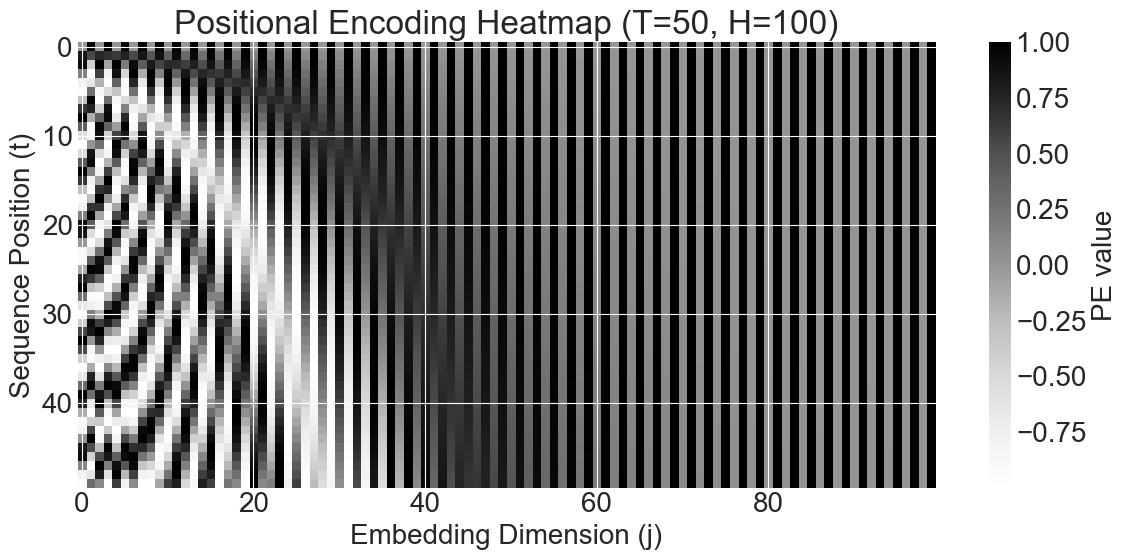

In [0]:
pe_layer = PositionalEncoding('pe100', embed_dim=100, prev_layer_or_block=None)

#We just want PE, so wewill plug in 0
zero_input = tf.zeros((1, 50, 100), dtype=tf.float32)
net_in = pe_layer.compute_net_input(zero_input)(1, 50, 100)

pos_encoding = net_in[0].numpy()#(50, 100)

plt.figure(figsize=(12, 6))
plt.imshow(pos_encoding, aspect='auto')
plt.xlabel('Embedding Dimension (j)')
plt.ylabel('Sequence Position (t)')
plt.title('Positional Encoding Heatmap (T=50, H=100)')
plt.colorbar(label='PE value')
plt.tight_layout()
plt.show()

### 4c. Implement `PositionalEncodingBlock`

In a transformer neural network, the positional encoding layer is usually followed by a `Dropout` layer. Let's make a block to bundle these two layers together.

In [168]:
from transformer_blocks import PositionalEncodingBlock

#### Test: `PositionalEncodingBlock` (No dropout)

In [170]:
tf.random.set_seed(1)
x_test = tf.random.uniform(shape=(2, 5, 4))

peblock = PositionalEncodingBlock('testPElock', embed_dim=4, prev_layer_or_block=None, dropout_rate=0.)
test_net_acts = peblock(x_test)
print('netActs from your PE Block are:')
print(test_net_acts)
print('and should be:')
print('''tf.Tensor(
[[[ 0.1651  1.9015  0.631   1.4345]
  [ 1.1334  1.1828  0.9858  1.435 ]
  [ 1.5694  0.1887  0.6566  1.6142]
  [ 1.0305 -0.3622  0.562   1.0255]
  [-0.3159 -0.401   0.9262  1.8865]]

 [[ 0.7873  1.0596  0.0711  1.3084]
  [ 1.0927  1.4488  0.4815  1.2423]
  [ 1.5423  0.1699  0.93    1.5699]
  [ 0.6376 -0.3961  0.5714  1.4425]
  [-0.4643  0.0803  0.9597  1.6677]]], shape=(2, 5, 4), dtype=float32)''')

netActs from your PE Block are:
tf.Tensor(
[[[ 0.1651  1.9015  0.631   1.4345]
  [ 1.1334  1.1828  0.9858  1.435 ]
  [ 1.5694  0.1887  0.6566  1.6142]
  [ 1.0305 -0.3622  0.562   1.0255]
  [-0.3159 -0.401   0.9262  1.8865]]

 [[ 0.7873  1.0596  0.0711  1.3084]
  [ 1.0927  1.4488  0.4815  1.2423]
  [ 1.5423  0.1699  0.93    1.5699]
  [ 0.6376 -0.3961  0.5714  1.4425]
  [-0.4643  0.0803  0.9597  1.6677]]], shape=(2, 5, 4), dtype=float32)
and should be:
tf.Tensor(
[[[ 0.1651  1.9015  0.631   1.4345]
  [ 1.1334  1.1828  0.9858  1.435 ]
  [ 1.5694  0.1887  0.6566  1.6142]
  [ 1.0305 -0.3622  0.562   1.0255]
  [-0.3159 -0.401   0.9262  1.8865]]

 [[ 0.7873  1.0596  0.0711  1.3084]
  [ 1.0927  1.4488  0.4815  1.2423]
  [ 1.5423  0.1699  0.93    1.5699]
  [ 0.6376 -0.3961  0.5714  1.4425]
  [-0.4643  0.0803  0.9597  1.6677]]], shape=(2, 5, 4), dtype=float32)


#### Test: `PositionalEncodingBlock` (Dropout 1/2)

Training mode

In [171]:
tf.random.set_seed(1)
x_test = tf.random.uniform(shape=(2, 5, 4))

peblock = PositionalEncodingBlock('testPElock', embed_dim=4, prev_layer_or_block=None, dropout_rate=0.5)
peblock.set_mode(is_training=True)
test_net_acts = peblock(x_test)
print('netActs from your PE Block are:')
print(test_net_acts)
print('and should be:')
print('''tf.Tensor(
[[[ 0.      3.803   1.2619  0.    ]
  [ 0.      2.3656  1.9716  0.    ]
  [ 3.1388  0.      1.3133  0.    ]
  [ 0.     -0.      1.1239  2.0511]
  [-0.     -0.      0.      0.    ]]

 [[ 1.5746  0.      0.1422  0.    ]
  [ 0.      2.8975  0.      2.4847]
  [ 0.      0.      0.      0.    ]
  [ 1.2751 -0.      0.      0.    ]
  [-0.      0.1606  1.9194  0.    ]]], shape=(2, 5, 4), dtype=float32)''')

netActs from your PE Block are:
tf.Tensor(
[[[ 0.3303  0.      0.      2.8691]
  [ 2.2668  0.      0.      2.8701]
  [ 0.      0.3775  0.      3.2285]
  [ 2.0609 -0.7245  0.      0.    ]
  [-0.6319 -0.8019  1.8524  3.773 ]]

 [[ 0.      2.1191  0.      2.6168]
  [ 2.1853  0.      0.963   0.    ]
  [ 3.0846  0.3398  1.86    3.1399]
  [ 0.     -0.7922  1.1429  2.8849]
  [-0.9286  0.      0.      3.3354]]], shape=(2, 5, 4), dtype=float32)
and should be:
tf.Tensor(
[[[ 0.      3.803   1.2619  0.    ]
  [ 0.      2.3656  1.9716  0.    ]
  [ 3.1388  0.      1.3133  0.    ]
  [ 0.     -0.      1.1239  2.0511]
  [-0.     -0.      0.      0.    ]]

 [[ 1.5746  0.      0.1422  0.    ]
  [ 0.      2.8975  0.      2.4847]
  [ 0.      0.      0.      0.    ]
  [ 1.2751 -0.      0.      0.    ]
  [-0.      0.1606  1.9194  0.    ]]], shape=(2, 5, 4), dtype=float32)


Option 2 (for alternate dropout implementation)

In [172]:
tf.random.set_seed(1)
x_test = tf.random.uniform(shape=(2, 5, 4))

peblock = PositionalEncodingBlock('testPElock', embed_dim=4, prev_layer_or_block=None, dropout_rate=0.5)
peblock.set_mode(is_training=True)
test_net_acts = peblock(x_test)
print('netActs from your PE Block are:')
print(test_net_acts)
print('and should be:')
print('''tf.Tensor(
[[[ 0.3303  0.      0.      2.8691]
  [ 2.2668  0.      0.      2.8701]
  [ 0.      0.3775  0.      3.2285]
  [ 2.0609 -0.7245  0.      0.    ]
  [-0.6319 -0.8019  1.8524  3.773 ]]

 [[ 0.      2.1191  0.      2.6168]
  [ 2.1853  0.      0.963   0.    ]
  [ 3.0846  0.3398  1.86    3.1399]
  [ 0.     -0.7922  1.1429  2.8849]
  [-0.9286  0.      0.      3.3354]]], shape=(2, 5, 4), dtype=float32)''')

netActs from your PE Block are:
tf.Tensor(
[[[ 0.3303  0.      0.      2.8691]
  [ 2.2668  0.      0.      2.8701]
  [ 0.      0.3775  0.      3.2285]
  [ 2.0609 -0.7245  0.      0.    ]
  [-0.6319 -0.8019  1.8524  3.773 ]]

 [[ 0.      2.1191  0.      2.6168]
  [ 2.1853  0.      0.963   0.    ]
  [ 3.0846  0.3398  1.86    3.1399]
  [ 0.     -0.7922  1.1429  2.8849]
  [-0.9286  0.      0.      3.3354]]], shape=(2, 5, 4), dtype=float32)
and should be:
tf.Tensor(
[[[ 0.3303  0.      0.      2.8691]
  [ 2.2668  0.      0.      2.8701]
  [ 0.      0.3775  0.      3.2285]
  [ 2.0609 -0.7245  0.      0.    ]
  [-0.6319 -0.8019  1.8524  3.773 ]]

 [[ 0.      2.1191  0.      2.6168]
  [ 2.1853  0.      0.963   0.    ]
  [ 3.0846  0.3398  1.86    3.1399]
  [ 0.     -0.7922  1.1429  2.8849]
  [-0.9286  0.      0.      3.3354]]], shape=(2, 5, 4), dtype=float32)


#### Test: `PositionalEncodingBlock` (Dropout 2/2)

Prediction mode

In [173]:
peblock.set_mode(is_training=False)
test_net_acts = peblock(x_test)
print('netActs from your PE Block are:')
print(test_net_acts)
print('and should be:')
print('''tf.Tensor(
[[[ 0.1651  1.9015  0.631   1.4345]
  [ 1.1334  1.1828  0.9858  1.435 ]
  [ 1.5694  0.1887  0.6566  1.6142]
  [ 1.0305 -0.3622  0.562   1.0255]
  [-0.3159 -0.401   0.9262  1.8865]]

 [[ 0.7873  1.0596  0.0711  1.3084]
  [ 1.0927  1.4488  0.4815  1.2423]
  [ 1.5423  0.1699  0.93    1.5699]
  [ 0.6376 -0.3961  0.5714  1.4425]
  [-0.4643  0.0803  0.9597  1.6677]]], shape=(2, 5, 4), dtype=float32)''')

netActs from your PE Block are:
tf.Tensor(
[[[ 0.1651  1.9015  0.631   1.4345]
  [ 1.1334  1.1828  0.9858  1.435 ]
  [ 1.5694  0.1887  0.6566  1.6142]
  [ 1.0305 -0.3622  0.562   1.0255]
  [-0.3159 -0.401   0.9262  1.8865]]

 [[ 0.7873  1.0596  0.0711  1.3084]
  [ 1.0927  1.4488  0.4815  1.2423]
  [ 1.5423  0.1699  0.93    1.5699]
  [ 0.6376 -0.3961  0.5714  1.4425]
  [-0.4643  0.0803  0.9597  1.6677]]], shape=(2, 5, 4), dtype=float32)
and should be:
tf.Tensor(
[[[ 0.1651  1.9015  0.631   1.4345]
  [ 1.1334  1.1828  0.9858  1.435 ]
  [ 1.5694  0.1887  0.6566  1.6142]
  [ 1.0305 -0.3622  0.562   1.0255]
  [-0.3159 -0.401   0.9262  1.8865]]

 [[ 0.7873  1.0596  0.0711  1.3084]
  [ 1.0927  1.4488  0.4815  1.2423]
  [ 1.5423  0.1699  0.93    1.5699]
  [ 0.6376 -0.3961  0.5714  1.4425]
  [-0.4643  0.0803  0.9597  1.6677]]], shape=(2, 5, 4), dtype=float32)
